# Preliminary analysis

In [1]:
seed = 0

In [2]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, Booster, DMatrix

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # XGB
    models.append(XGBClassifier(use_label_encoder=False))
    names.append('XGB')
    return models, names

No se muestran pero las variable de constraints (eliminadas por los autores originales) presentan un alta correlación con el status

In [4]:
import os
import inspect

In [5]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)


In [6]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [21]:
from sklearn.metrics import confusion_matrix, f1_score


In [ ]:
confusion_matrix()
f1_score()

## Baseline

### Dummy Classifier

In [6]:
from sklearn.metrics import f1_score

In [7]:
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X_train, y_train, model, f1_score)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

min: 0.1956521739130435
max: 0.1962546816479401
mean: 0.1957726754600228
Mean F2: 0.196 (0.000)


### Logistic Regression

In [13]:
%%time
model = LogisticRegression(max_iter=1000)
norm = Normalizer()
model = Pipeline([('nr', norm),('lr', model)])
scores = evaluate_model(X_train, y_train, model, f1_score)
print('min:', np.min(scores))
print('max:', np.max(scores))
print('mean:', np.mean(scores))

min: 0.05
max: 0.1111111111111111
mean: 0.08415528199655617
min: 0.05
max: 0.1111111111111111
mean: 0.08415528199655617
Wall time: 359 ms


In [7]:
model.fit(X_train, y_train)

Pipeline(steps=[('nr', Normalizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [8]:
balanced_accuracy_score(y_test, model.predict(X_test))

0.5242100340933256

## Modeling

### XGboost GridSearch

In [26]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

In [29]:
%%time
model = XGBClassifier(use_label_encoder=False)

Wall time: 0 ns


In [44]:
scale_pos_weight = [1, 10, 25, 50, 75, 99] # Incluir menores a 1
max_depth = list(range(4,11))
gamma = [0, .5, 1]
learning_rate = [.0001, .001, .01, .1, 1] # Reducir el rango
n_estimators = [100, 200, 500]

param_grid = dict(scale_pos_weight=scale_pos_weight, 
                  max_depth=max_depth, 
                  gamma=gamma, 
                  learning_rate=learning_rate, 
                  n_estimators=n_estimators)

In [33]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=10)

In [57]:
list(param_grid.values())

[[1, 10, 25, 50, 75, 99],
 [4, 5, 6, 7, 8, 9, 10],
 [0, 0.5, 1],
 [0.0001, 0.001, 0.01, 0.1, 1],
 [100, 200, 500]]

In [59]:
models = 1
for listElem in list(param_grid.values()):
     models = models * len(listElem)
        
models * 

In [61]:
models

1890

In [15]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
[17:18:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2h 11min 39s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=0),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     val

In [62]:
import joblib
import os

if not os.path.exists('GridSearchCV1.pkl'):
    joblib.dump(grid, 'GridSearchCV1.pkl')
grid = joblib.load('GridSearchCV1.pkl')

In [8]:
### Best model
model = grid.best_estimator_
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
evaluate_model(X, y, model, f1_macro)

min: 0.7028484499465728
max: 0.7385878743855994
mean: 0.7206210395392343


array([0.70996659, 0.72754437, 0.72493057, 0.73291863, 0.70498047,
       0.71760653, 0.71690108, 0.71906332, 0.72223601, 0.72895094,
       0.73858787, 0.70284845, 0.73348407, 0.71086727, 0.71842943])

#### Grid results

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2683
           1       0.73      0.37      0.50       326

    accuracy                           0.92      3009
   macro avg       0.83      0.68      0.73      3009
weighted avg       0.91      0.92      0.91      3009



In [25]:
print("Current Time =", current_time)

Current Time = 10-03-22_13:34:06


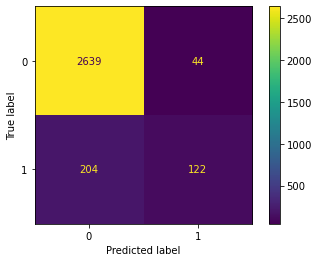

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
if not os.path.exists('figures/XGBoost_best'):
    os.makedirs('figures/XGBoost_best')
plt.savefig('figures/XGBoost_best/confusion_matrix_xgb.pdf', bbox_inches='tight')

In [6]:
model = XGBClassifier()
model.load_model(fname='..\\Replication\\[Replication] Explainable Machine Learning in credit risk management\\Replication code\\repli.model')


C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\xgboost\sklearn.py:604: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn(


In [8]:
model.fit(X_train, y_train)

C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:34:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
evaluate_model(X, y, model, f1)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2683
           1       0.68      0.38      0.49       326

    accuracy                           0.91      3009
   macro avg       0.80      0.68      0.72      3009
weighted avg       0.90      0.91      0.90      3009



In [20]:
balanced_accuracy_score(y_test, y_pred)

0.7803793025388208

In [64]:
grid_results = pd.DataFrame(grid.cv_results_)
params_columns = grid_results.columns.to_numpy(str)[np.char.startswith(grid_results.columns.to_numpy(str), 'param_')]

In [67]:
grid_results.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000
mean,9.892629,0.308830,0.010191,0.000767,0.807156,0.796223,0.825150,0.806159,0.835650,0.814068,0.016039,945.301058
std,7.729245,0.434617,0.003305,0.001181,0.020916,0.021246,0.025183,0.024668,0.020327,0.020747,0.004971,545.649289
min,1.562470,0.002531,0.006201,0.000000,0.745972,0.733911,0.747945,0.749183,0.772629,0.757517,0.004125,1.000000
25%,4.259414,0.069066,0.007802,0.000400,0.791529,0.779644,0.808656,0.786320,0.823735,0.798713,0.012266,473.250000
50%,7.297860,0.162878,0.009002,0.000490,0.804884,0.795766,0.825023,0.803392,0.836910,0.812191,0.015806,945.000000
75%,12.589724,0.358709,0.011403,0.000749,0.819794,0.811047,0.843661,0.824404,0.850120,0.827529,0.019814,1417.500000
max,38.015926,4.054630,0.027006,0.019508,0.861665,0.845367,0.877339,0.865492,0.875420,0.862063,0.028068,1890.000000


In [65]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.128679,0.142759,0.009002,0.001674,0,0.0001,4,100,1,"{'gamma': 0, 'learning_rate': 0.0001, 'max_dep...",0.773674,0.794181,0.805682,0.806612,0.822710,0.800572,0.016230,1332
1,2.024255,0.084089,0.008402,0.001020,0,0.0001,4,100,10,"{'gamma': 0, 'learning_rate': 0.0001, 'max_dep...",0.824567,0.804197,0.844384,0.818179,0.840485,0.826362,0.014736,503
2,2.016254,0.064309,0.008202,0.001166,0,0.0001,4,100,25,"{'gamma': 0, 'learning_rate': 0.0001, 'max_dep...",0.814367,0.798959,0.850119,0.792407,0.841184,0.819407,0.022760,719
3,1.997050,0.086829,0.007602,0.000490,0,0.0001,4,100,50,"{'gamma': 0, 'learning_rate': 0.0001, 'max_dep...",0.797690,0.801298,0.833200,0.783378,0.827800,0.808673,0.018880,1085
4,1.940237,0.153457,0.008402,0.001855,0,0.0001,4,100,75,"{'gamma': 0, 'learning_rate': 0.0001, 'max_dep...",0.797108,0.784657,0.831234,0.800428,0.833079,0.809301,0.019397,1063


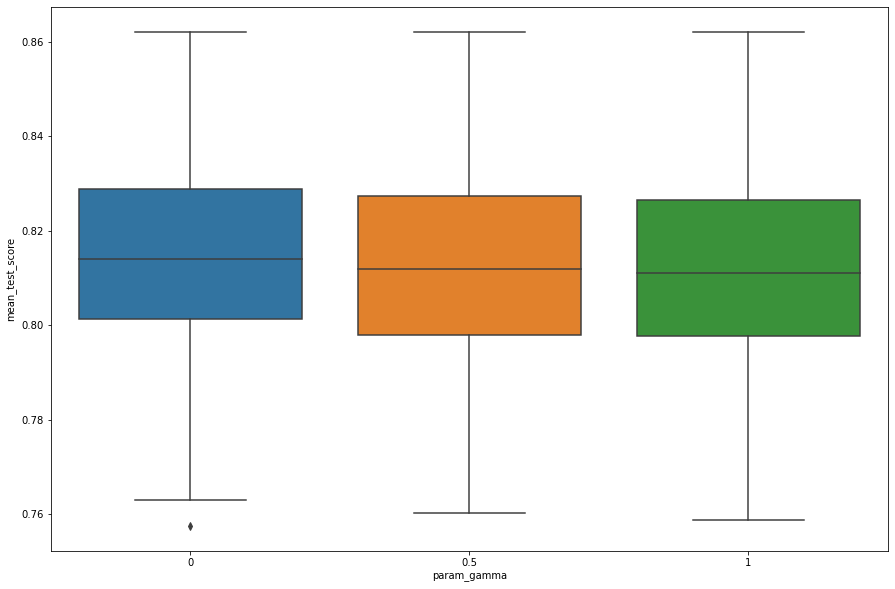

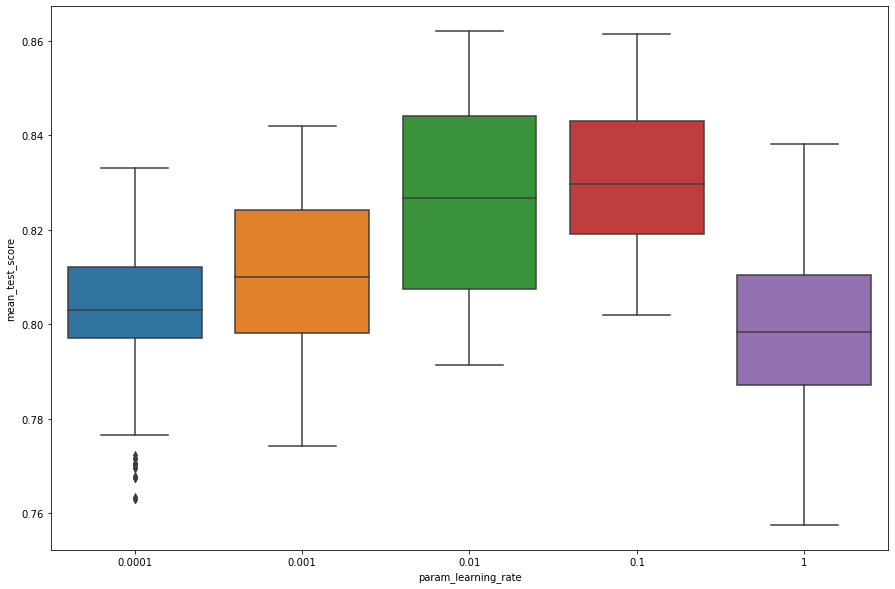

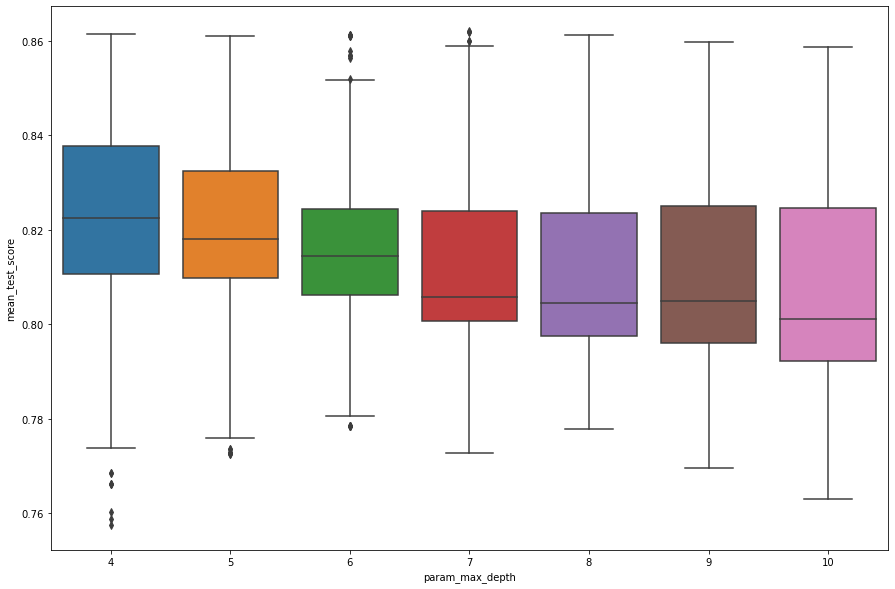

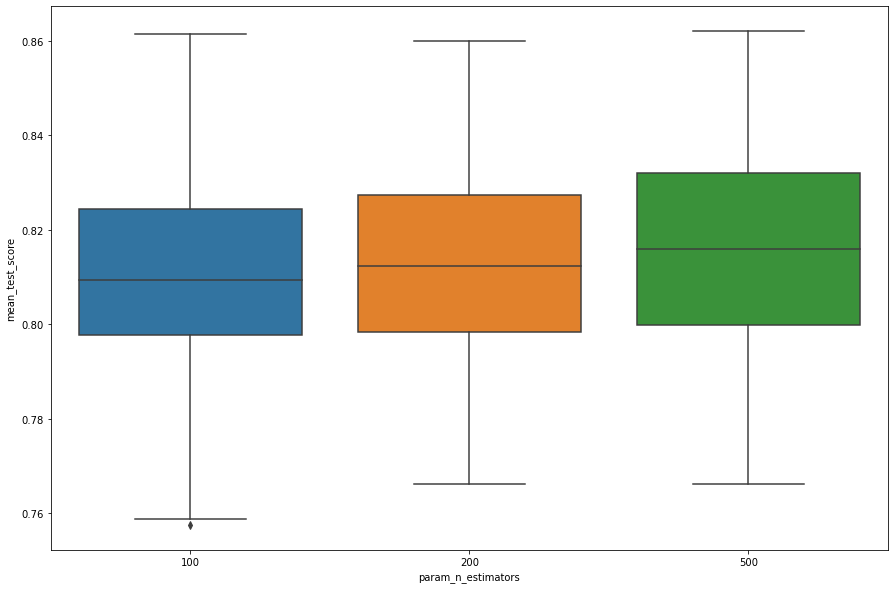

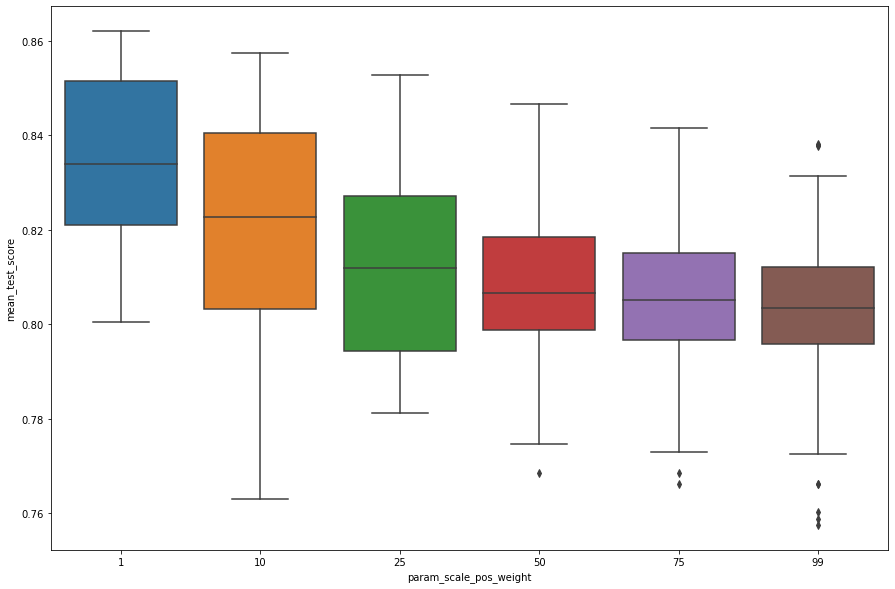

In [16]:
for param in params_columns:
    plt.figure(figsize=(15,10))
    sns.boxplot(data=grid_results, x=param, y='mean_test_score')
    plt.savefig('./figures/{}.png'.format(param), bbox_inches='tight', dpi=300, transparent=True)

### XGBoost Bayesian optimization

In [14]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [15]:
%%time
model = XGBClassifier(use_label_encoder=False)

Wall time: 0 ns


In [33]:
scale_pos_weight = Integer(1, 50)
max_depth = Integer(2, 10)
learning_rate = Real(.001, 1)
n_estimators = Integer(500,1000)
reg_lambda = Real(0, 2)
reg_alpha = Real(0, 2)

param_grid = dict(scale_pos_weight=scale_pos_weight, 
                  max_depth=max_depth,
                  learning_rate=learning_rate, 
                  n_estimators=n_estimators, 
                  reg_lambda=reg_lambda, 
                  reg_alpha=reg_alpha)

In [34]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
# define grid search
grid = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=100, n_jobs=-1, cv=cv, scoring=make_scorer(f1_score), verbose=10)

In [26]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [35]:
%%time
grid.fit(X_train, y_train, sample_weight=sample_weights)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

KeyboardInterrupt: 

In [19]:
grid.best_score_

0.7809372942302661

In [12]:
import joblib
import os

if not os.path.exists('BayesianSearchCV1.pkl'):
    joblib.dump(grid, 'BayesianSearchCV1.pkl')
grid = joblib.load('BayesianSearchCV1.pkl')

In [13]:
### Best model
model = grid.best_estimator_
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.023085729923658267,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2683
           1       0.31      0.77      0.44       326

    accuracy                           0.79      3009
   macro avg       0.64      0.78      0.66      3009
weighted avg       0.89      0.79      0.82      3009



In [21]:
from sklearn.metrics import f1_score

In [38]:
f1_score(y_test, y_pred, average='weighted')

0.824922252502603

## Shap Values

In [17]:
import shap

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

In [18]:
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_20,V_21,V_22,V_23
1432,0.012587,0.008188,-0.060455,0.377878,-0.029254,-0.101507,-0.070402,-0.102398,-0.037475,0.197132,-0.054743,-0.100303,-0.167516,0.037134,0.005664,-0.023519,0.876308,0.045098,0.163658
6854,0.307186,-0.173447,0.309172,0.233966,0.112318,-0.052940,-0.187733,-0.148139,-0.024850,-0.052160,-0.015214,-0.126066,-0.281934,-0.022594,-0.023150,0.015597,0.439395,-0.283589,0.044948
9463,-0.074259,-0.076292,-0.720510,0.337453,-0.022887,-0.169799,-0.007329,0.110456,-0.066407,-0.121960,-0.129274,-0.118069,0.843314,-0.062316,-0.035999,-0.022103,0.500363,0.102333,-0.105872
8404,-0.024090,0.043411,-0.209694,0.033881,-0.003803,-0.058488,-0.000695,-0.078160,-0.101725,0.244391,0.305455,-0.053660,-0.386324,-0.056057,0.003741,-0.015225,-0.175137,-0.190467,-0.162796
7410,-0.051722,0.047391,-0.111160,-0.250409,-0.016635,-0.031892,-0.095316,-0.078288,-0.091901,-0.050348,0.006950,-0.079797,-0.277315,-0.039614,-0.028193,-0.038574,-0.117824,-0.060582,-0.115089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.008755,-0.007641,-0.316172,-0.071042,-0.008546,-0.154908,0.021124,0.277889,-0.263678,-0.019420,-0.048611,-0.055724,-0.430095,0.073510,-0.008477,-0.055334,0.008856,-0.028970,-0.206546
13040,-0.122756,0.053095,-0.443844,-0.221841,0.109273,0.084428,-0.013022,0.562553,-0.156270,-0.074973,0.126747,-0.022169,-0.539187,0.081933,-0.034556,-0.038889,-0.124726,-0.036210,0.643053
5466,-0.047265,-0.088392,-0.355919,-0.662143,0.162799,0.122982,0.014738,-0.185809,0.080032,-0.110445,-0.110405,0.057913,1.049889,0.076299,-0.018422,0.033112,-0.060914,-0.056025,0.117232
6397,0.066365,-0.178849,0.023870,0.206849,-0.002150,-0.068853,-0.089410,-0.099417,-0.043855,0.043954,0.050439,-0.080324,-0.620647,0.003615,-0.024753,-0.123134,-0.244990,-0.161693,-0.047863


In [19]:
shap_df.iloc[1432]

V_1     0.021400
V_2    -0.181161
V_3    -0.005545
V_4     0.296796
V_5    -0.025540
V_6     0.263591
V_7    -0.022022
V_8    -0.116590
V_9    -0.112502
V_10   -0.028313
V_11   -0.029054
V_12   -0.057399
V_13   -0.774243
V_14   -0.003537
V_15   -0.022723
V_20   -0.050879
V_21    0.430752
V_22   -0.246371
V_23    0.008117
Name: 13784, dtype: float32

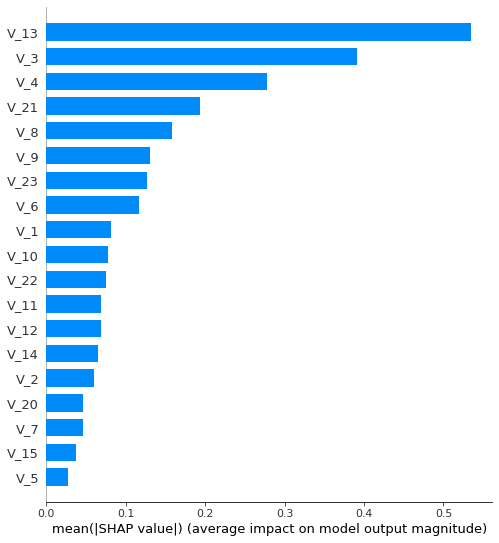

In [21]:
shap.summary_plot(shap_test, plot_type='bar', show=False)
plt.savefig('figures/feature_importance.png', bbox_inches='tight', dpi=300, transparent=True)

In [56]:
model.predict_proba(X_test)

array([[0.7979324 , 0.20206764],
       [0.90709984, 0.09290015],
       [0.89922595, 0.10077404],
       ...,
       [0.91135037, 0.0886496 ],
       [0.97680473, 0.02319524],
       [0.9542815 , 0.04571848]], dtype=float32)

In [30]:
np.argsort([1,2,3])

array([0, 1, 2], dtype=int64)

In [33]:
y_test

1432     1
6854     0
9463     0
8404     0
7410     0
        ..
2195     0
13040    0
5466     0
6397     0
11513    0
Name: status, Length: 3009, dtype: int64

In [34]:
y_test.values[idx]

0

In [25]:
np.argsort(model.predict_proba(X_test)[:,1])

array([1076, 2492, 1767, ..., 2060,  823, 1128], dtype=int64)

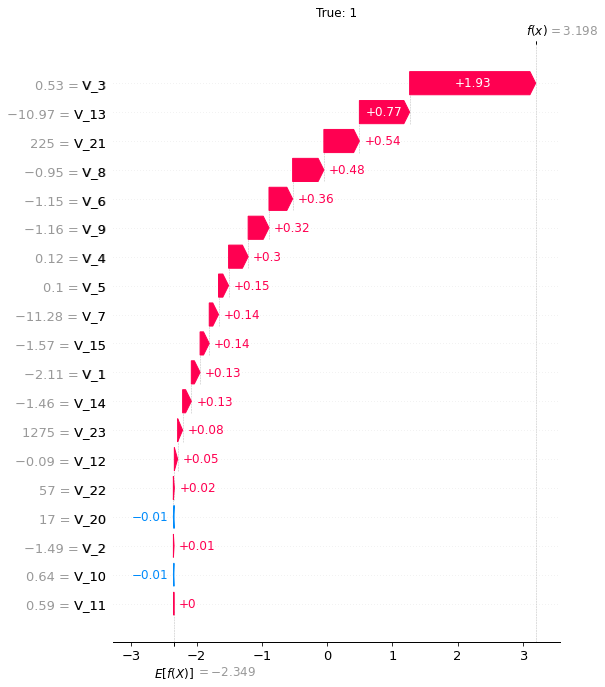

In [36]:
idx = 1128
sample_idx = shap_df.index[idx]
shap.plots.waterfall(shap_test[idx], max_display=19, show=False)
if not os.path.exists('figures/XGBoost_SHAP'):
    os.makedirs('figures/XGBoost_SHAP')
plt.title('True: {}'.format(y_test.values[idx]))
plt.savefig('figures/XGBoost_SHAP/waterfall{}_xgb.png'.format(sample_idx), bbox_inches='tight', dpi=300, transparent=True)

Los más importantes son  Operating revenues/Total assets,  Sales/Total assets,  EBITDA/interest paid

In [76]:
np.mean(model.predict_proba(X_train)[:,1]/(1 - model.predict_proba(X_train)[:,1] ))

0.45809796

In [59]:
np.mean(y_train)

0.10850780990362247

In [39]:
odds = np.exp(-1.3)
odds / (1 + odds)

0.2141650169574414

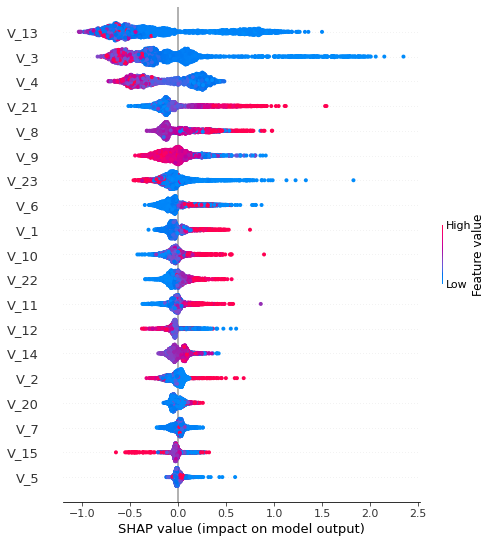

In [41]:
shap.plots.beeswarm(shap_test, max_display=19, show=False)
plt.savefig('figures/XGBoost_SHAP/beeswarm.png', bbox_inches='tight', dpi=300, transparent=True)

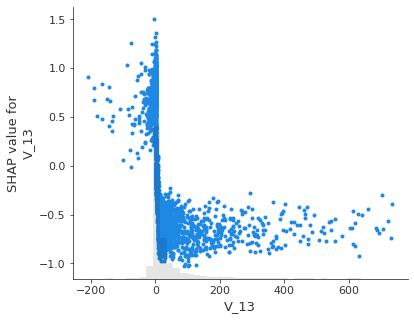

In [43]:
shap.plots.scatter(shap_test[:,12], show=False)
plt.savefig('figures/XGBoost_SHAP/xgb_V_13_PD.png', bbox_inches='tight', dpi=300, transparent=True)

V13- EBITDA/Interest paid. Si el valor es negativo la probabilidad de impago crece mucho, esto implica perdidas en la empresa

## Graph representation

In [44]:
from igraph import Graph
import igraph as ig
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
%%time
shap_dist = euclidean_distances(shap_df)
# Scale distances 0 - 1
#normalized_dist = MinMaxScaler().fit_transform(shap_dist)
#n = normalized_dist.shape[0]

fullg = Graph.Weighted_Adjacency(shap_dist, mode='undirected')

Wall time: 1.02 s


In [13]:
y_test.iloc[np.argsort(y_test).values]

11513    0
12799    0
7918     0
4214     0
6567     0
        ..
1478     1
662      1
417      1
929      1
831      1
Name: status, Length: 3009, dtype: int64

In [27]:
shap_dist

array([[0.       , 0.8437696, 1.3657104, ..., 1.9488568, 1.293633 ,
        1.4419842],
       [0.8437696, 0.       , 1.6797823, ..., 1.8980588, 0.8989283,
        1.2161136],
       [1.3657104, 1.6797823, 0.       , ..., 1.359958 , 1.8737935,
        1.4457265],
       ...,
       [1.9488568, 1.8980588, 1.359958 , ..., 0.       , 1.9949186,
        1.0379479],
       [1.293633 , 0.8989283, 1.8737935, ..., 1.9949186, 0.       ,
        1.1604419],
       [1.4419842, 1.2161136, 1.4457265, ..., 1.0379479, 1.1604419,
        0.       ]], dtype=float32)

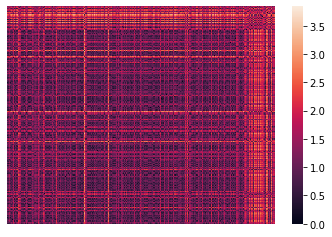

In [47]:
ax = sns.heatmap(shap_dist[np.argsort(y_test).values][:,np.argsort(y_test).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()
if not os.path.exists('figures/XGBoost_Graph'):
    os.makedirs('figures/XGBoost_Graph')
plt.savefig('figures/XGBoost_Graph/adjmatrix_xgb.png', bbox_inches='tight', dpi=300, transparent=True)

In [28]:
degree = fullg.degree_distribution()
strengths = fullg.strength(fullg.vs, weights=fullg.es['weight'])

In [43]:
y_pred = model.predict(X_test)

In [52]:
# Comparar con una red aleatoria Reini Modelo Erdös–Rényi
mod = fullg.modularity(y_test.to_list(), weights=fullg.es['weight'])
mod

-0.013987853248393174

The higher the modularity score of a community structure, the denser the within-community connectivity compared to between-community connectivity, and, hence, the better the quality of the structure. In a weighted network the modularity of a specific division of the network into communities, is the sum over all communities of the total weight of the edges in a community minus the total weight expected by chance in the community


7.7.1 Assortative mixing by unordered characteristic

### Edge cut off by distance

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [83]:
%%time

cutoffs = np.array(range(1,11))/10
clustering_coeffs = []
random_clustering_coeffs = []
for co in cutoffs:
    # Reduced graph
    adj_matrix = (normalized_dist < co)*1
    reduced_G = Graph.Adjacency(adj_matrix, mode='undirected')
    clustering_coeffs.append(reduced_G.transitivity_undirected())
    
    # Corresponding random clustering coefficient
    degrees = reduced_G.degree(reduced_G.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    random_clustering_coeffs.append( (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3) )

Wall time: 1min 8s


In [86]:
## Greater differences means deviation from random structure
np.array(clustering_coeffs) - np.array(random_clustering_coeffs)

array([0.43640759, 0.31169328, 0.11046916, 0.07838565, 0.02719356,
       0.00954005, 0.00268447, 0.00109877, 0.00099613, 0.0009969 ])

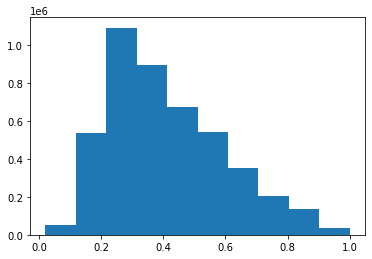

In [20]:
normalized_dist = MinMaxScaler().fit_transform(shap_dist)
indices = np.tril_indices_from(normalized_dist,k=-1)
plt.hist(normalized_dist[indices])
if not os.path.exists('figures/XGBoost_Graph'):
    os.makedirs('figures/XGBoost_Graph')
plt.savefig('figures/XGBoost_Graph/dist_xgb.pdf', bbox_inches='tight')

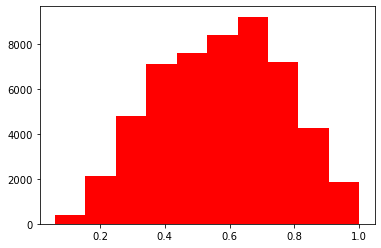

In [21]:
shap_dist_default = euclidean_distances(shap_df[y_test.astype(bool)])
normalized_dist = MinMaxScaler().fit_transform(shap_dist_default)
indices = np.tril_indices_from(normalized_dist,k=-1)
plt.hist(normalized_dist[indices], color='red')
if not os.path.exists('figures/XGBoost_Graph'):
    os.makedirs('figures/XGBoost_Graph')
plt.savefig('figures/XGBoost_Graph/dist_impago_xgb.pdf', bbox_inches='tight')

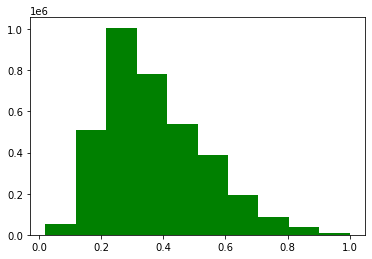

In [22]:
shap_dist_default = euclidean_distances(shap_df[~y_test.astype(bool)])
normalized_dist = MinMaxScaler().fit_transform(shap_dist_default)
indices = np.tril_indices_from(normalized_dist,k=-1)
plt.hist(normalized_dist[indices], color='green')
if not os.path.exists('figures/XGBoost_Graph'):
    os.makedirs('figures/XGBoost_Graph')
plt.savefig('figures/XGBoost_Graph/dist_corriente_xgb.pdf', bbox_inches='tight')

In [157]:
y_proba = model.predict_proba(X_test)[:,1]

In [163]:
print('max_distance', np.unravel_index(shap_dist.argmax(), shap_dist.shape))
print('default proba 2023', y_proba[2023])
print('default proba 1433', y_proba[1433])

max_distance (1433, 2023)
default proba 2023 0.9108387
default proba 1433 0.011176866


### Community detection

In [ ]:
## Probar con pocos nodos e ir creciendo la red: Anotar tiempos

In [ ]:
%%time
communities = fullg.community_edge_betweenness(weights=fullg.es['weight'])

In [26]:
communities_clusters = communities.as_clustering(2)

In [ ]:
communities_clusters.modularity

In [47]:
for i, community in enumerate(communities):
    print(f"Community {i}:")
    for v in community:
        print(f"\t{fullg.vs[v]['label']}")

Community 0:


KeyError: 'Attribute does not exist'

In [45]:
tt = com_spinglass.as_clustering(n=2)

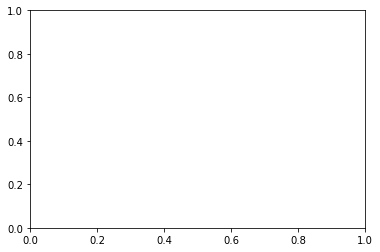

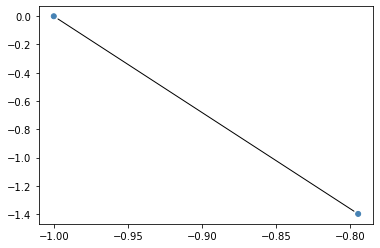

In [38]:
fig, ax = plt.subplots()
cg = tt.cluster_graph()
fig2, ax2 = plt.subplots()
ig.plot(
    cg,
    target=ax2
)

In [ ]:
%%time
com_spinglass = fullg.community_spinglass(weights=fullg.es['weight'])

### MST representation

In [59]:
mst = fullg.spanning_tree(fullg.es['weight'])
colors = np.array(['#808080']*y_test.shape[0])
colors[y_test == 1] = '#FF0000'
mst.vs['color'] = colors.tolist()
#mst.layout_davidson_harel()

In [60]:
mod = mst.modularity(y_test.to_list(), weights=mst.es['weight'])
mod

0.09436321442605898

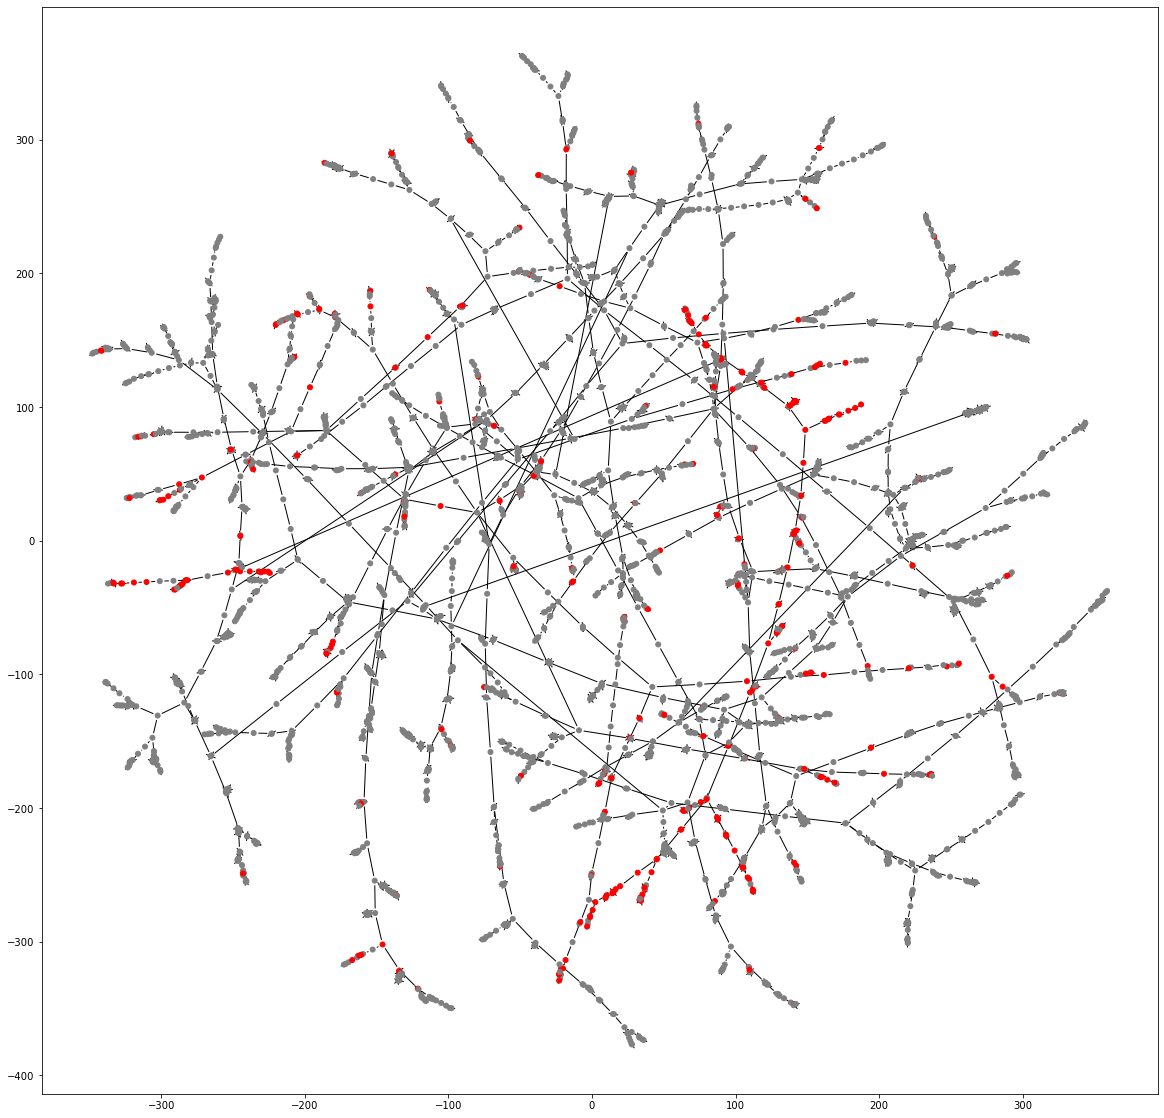

In [61]:
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(mst, target=ax, vertex_color = mst.vs['color'])
if not os.path.exists('figures/XGBoost_Graph'):
    os.makedirs('figures/XGBoost_Graph')
plt.savefig('figures/XGBoost_Graph/mst_xgb.pdf', bbox_inches='tight')

In [ ]:
layout = mst.layout_davidson_harel()


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(mst, layout=layout, target=ax, vertex_color=mst.vs['color'])

## Alternative models

In [57]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold

In [58]:
def get_models():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')
    # ENN
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # OSS
    models.append(OneSidedSelection())
    names.append('OSS')
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    # IHT
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    return models, names

In [59]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = LogisticRegression(solver='liblinear', class_weight='balanced')
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    pipeline.fit(X_train, y_train)
    print(balanced_accuracy_score(y_test, model.predict(X_test)))

X has feature names, but LogisticRegression was fitted without feature names


0.6675123305337629


X has feature names, but LogisticRegression was fitted without feature names


0.631065513606461


X has feature names, but LogisticRegression was fitted without feature names


0.6259760957997298


X has feature names, but LogisticRegression was fitted without feature names


0.6729447395439132


X has feature names, but LogisticRegression was fitted without feature names


0.6384752669043214
0.5912608127976878


X has feature names, but LogisticRegression was fitted without feature names


In [62]:
pipeline.predict(X)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [74]:
def example(X):
    return np.array([[1,0]]*X.shape[0])

In [75]:
example(X)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

In [111]:
pipeline.named_steps

{'nr': Normalizer(),
 's': InstanceHardnessThreshold(),
 'm': LogisticRegression(class_weight='balanced', solver='liblinear')}

In [158]:
explainer = shap.LinearExplainer(pipeline.named_steps['m'], pipeline.named_steps['s'].fit_resample(pipeline.named_steps['nr'].transform(X_train), y_train)[0])
shap_test = explainer(pipeline.named_steps['nr'].transform(X_test))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

Exception: An unknown model type was passed: <class 'method'>

In [141]:
pipeline.predict_log_proba(X_test.iloc[3:4])

array([[-0.42241721, -1.06554659]])

In [135]:
pipeline.predict_proba(X_test.iloc[2:3])

array([[0.05324522, 0.94675478]])

In [143]:
np.exp(-0.643)

0.5257129172157903

In [171]:
pipeline.named_steps['m'].predict(pipeline.named_steps['nr'].transform(X_test.iloc[3:4]))

array([0], dtype=int64)

In [155]:
pipeline.named_steps['nr'].transform(X_test.iloc[0:1])

array([[1.21089610e-02, 0.00000000e+00, 1.97768130e-03, 1.71746008e-03,
        1.56132735e-03, 1.64806775e-03, 4.09414726e-03, 5.20442448e-05,
        2.60221224e-04, 1.26640996e-03, 1.26640996e-03, 7.28619428e-04,
        1.39825538e-02, 2.60221224e-04, 2.60221224e-04, 6.24530938e-02,
        5.60343036e-01, 7.02597305e-01, 4.33702040e-01]])

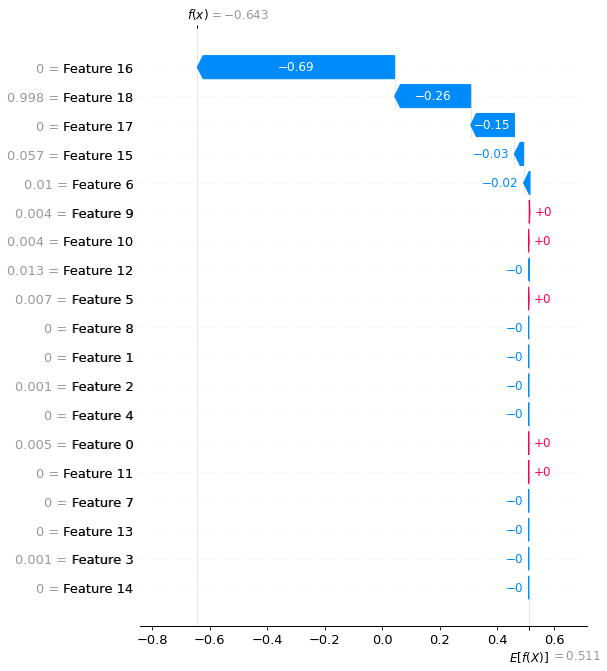

In [163]:
shap.plots.waterfall(shap_test[3], max_display=19)

Ya que se utiliza un modelo logístico, se muestran log-odds

In [117]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import InstanceHardnessThreshold

In [120]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# define the data sampling
sampling = InstanceHardnessThreshold()
# scale, then sample, then fit model
model = Pipeline(steps=[('nr',norm), ('s', sampling), ('m',model)])

In [121]:
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      2683
           1       0.20      0.62      0.30       326

    accuracy                           0.69      3009
   macro avg       0.57      0.66      0.55      3009
weighted avg       0.86      0.69      0.75      3009

